<a href="https://colab.research.google.com/github/VictorTini/Fase5_FIAP/blob/main/Pos_treinamento_modelo_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
!pip install google-cloud-bigquery
!pip install findspark

# 01 - Importando as bibliotecas necessárias

Neste primeiro passo, estamos importando as bibliotecas necessárias para manipulação de dados (pandas), visualização (matplotlib e seaborn) e leitura de arquivos JSON (json).

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns


# 02 - Carregando os dados

Aqui, carregamos o arquivo JSON com as vagas, extraímos as informações e criamos um DataFrame df_vagas.

In [3]:
caminho_vagas = r'vagas.json'
caminho_prospects = r'prospects.json'
caminho_applicants = r'applicants.json'

with open(caminho_vagas, encoding='utf-8') as f:
    raw_vagas = json.load(f)

lista_vagas = []
for id_vaga, dados in raw_vagas.items():
    dados['id_vaga'] = id_vaga
    lista_vagas.append(dados)

df_vagas = pd.json_normalize(lista_vagas)
print(f'Vagas carregadas: {df_vagas.shape}')


Vagas carregadas: (14081, 45)


# 03 - Carregando os prospects (candidatos potenciais)
Aqui, carregamos os prospects e estruturamos os dados de forma que cada candidato tenha um ID de vaga correspondente, criando o DataFrame df_prospeccoes.

In [4]:
with open(caminho_prospects, encoding='utf-8') as f:
    raw_prospects = json.load(f)

lista_prospects = []
for id_vaga, conteudo in raw_prospects.items():
    if isinstance(conteudo, list):
        for candidato in conteudo:
            if isinstance(candidato, dict):
                candidato['id_vaga'] = id_vaga
                lista_prospects.append(candidato)
    elif isinstance(conteudo, dict) and 'prospects' in conteudo:
        for candidato in conteudo['prospects']:
            if isinstance(candidato, dict):
                candidato['id_vaga'] = id_vaga
                lista_prospects.append(candidato)

df_prospeccoes = pd.json_normalize(lista_prospects)
print(f'Prospecções carregados: {df_prospeccoes.shape}')


Prospecções carregados: (53759, 8)


# 04 - Carregando os candidatos
Neste passo, fazemos o mesmo processo para carregar os candidatos, que são estruturados no DataFrame df_candidatos.

In [5]:
lista_candidatos = []
with open(caminho_applicants, encoding='utf-8') as f:
    try:
        raw_candidatos = json.load(f)
    except json.JSONDecodeError as e:
        print("Falha ao carregar JSON completo.Extrair manualmente!")

        f.seek(0)
        for i, linha in enumerate(f):
            try:
                candidato = json.loads(linha)
                lista_candidatos.append(candidato)
            except:
                print(f"Linha inválida na {i}")

with open(caminho_applicants, encoding='utf-8') as f:
    raw_candidatos = json.load(f)

lista_candidatos = []
for id_candidato, dados in raw_candidatos.items():
    dados['id_candidato'] = id_candidato
    lista_candidatos.append(dados)

df_candidatos = pd.json_normalize(lista_candidatos)
print(f'Candidatos carregados: {df_candidatos.shape}')


Candidatos carregados: (42482, 58)


# 05 - Visualizando os dados carregados
Aqui, fazemos uma visualização rápida das primeiras linhas de cada DataFrame para garantir que os dados foram carregados corretamente.

In [6]:
print("\nVagas:")
print(df_vagas.head())

print("\nProspecções:")
print(df_prospeccoes.head())

print("\nCandidatos:")
print(df_candidatos.head())



Vagas:
  id_vaga informacoes_basicas.data_requicisao  \
0    5185                          04-05-2021   
1    5184                          04-05-2021   
2    5183                          04-05-2021   
3    5182                          04-05-2021   
4    5181                          04-05-2021   

  informacoes_basicas.limite_esperado_para_contratacao  \
0                                         00-00-0000     
1                                         00-00-0000     
2                                         00-00-0000     
3                                         18-05-2021     
4                                         00-00-0000     

                     informacoes_basicas.titulo_vaga  \
0                                   Operation Lead -   
1                             Consultor PP/QM Sênior   
2                              ANALISTA PL/JR C/ SQL   
3                     Technical Architect - 11894809   
4  Consultor SAP AUTHORIZATION (BCA) -Pleno / Sênior   

  informaco

# 06 - Verificando as colunas dos DataFrames
Nesta etapa, verificamos as colunas disponíveis para cada DataFrame, o que nos ajuda a entender melhor os dados e como podemos usá-los nas análises.

In [7]:
print("Colunas disponíveis em df_vagas:")
print(df_vagas.columns.tolist())

print("Colunas disponíveis em df_prospeccoes:")
print(df_prospeccoes.columns.tolist())

print("Colunas disponíveis em df_candidatos:")
print(df_candidatos.columns.tolist())


Colunas disponíveis em df_vagas:
['id_vaga', 'informacoes_basicas.data_requicisao', 'informacoes_basicas.limite_esperado_para_contratacao', 'informacoes_basicas.titulo_vaga', 'informacoes_basicas.vaga_sap', 'informacoes_basicas.cliente', 'informacoes_basicas.solicitante_cliente', 'informacoes_basicas.empresa_divisao', 'informacoes_basicas.requisitante', 'informacoes_basicas.analista_responsavel', 'informacoes_basicas.tipo_contratacao', 'informacoes_basicas.prazo_contratacao', 'informacoes_basicas.objetivo_vaga', 'informacoes_basicas.prioridade_vaga', 'informacoes_basicas.origem_vaga', 'informacoes_basicas.superior_imediato', 'informacoes_basicas.nome', 'informacoes_basicas.telefone', 'perfil_vaga.pais', 'perfil_vaga.estado', 'perfil_vaga.cidade', 'perfil_vaga.bairro', 'perfil_vaga.regiao', 'perfil_vaga.local_trabalho', 'perfil_vaga.vaga_especifica_para_pcd', 'perfil_vaga.faixa_etaria', 'perfil_vaga.horario_trabalho', 'perfil_vaga.nivel profissional', 'perfil_vaga.nivel_academico', 'per

# 07 - Analisando valores nulos
Aqui, identificamos se existem valores ausentes nos DataFrames, o que pode afetar a qualidade da análise e da modelagem.

In [8]:
print("Valores nulos em df_vagas:")
print(df_vagas.isnull().sum().sort_values(ascending=False))

print("\nValores nulos em df_prospeccoes:")
print(df_prospeccoes.isnull().sum().sort_values(ascending=False))

print("\nValores nulos em df_candidatos:")
print(df_candidatos.isnull().sum().sort_values(ascending=False))


Valores nulos em df_vagas:
informacoes_basicas.nome_substituto                     13733
perfil_vaga.habilidades_comportamentais_necessarias     11396
informacoes_basicas.data_inicial                         9625
informacoes_basicas.data_final                           9625
informacoes_basicas.telefone                             4762
informacoes_basicas.nome                                 4456
perfil_vaga.equipamentos_necessarios                     2685
informacoes_basicas.superior_imediato                      42
id_vaga                                                     0
informacoes_basicas.data_requicisao                         0
informacoes_basicas.limite_esperado_para_contratacao        0
informacoes_basicas.titulo_vaga                             0
informacoes_basicas.vaga_sap                                0
informacoes_basicas.objetivo_vaga                           0
informacoes_basicas.prazo_contratacao                       0
informacoes_basicas.tipo_contratacao       

# 08 - Distribuição da situação dos candidatos

Aqui, plotamos a distribuição das situações dos candidatos, o que pode ser útil para entender como estão os resultados das prospecções.

/tmp/ipython-input-9-3941597885.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=situacao_counts.values, y=situacao_counts.index, palette="viridis")


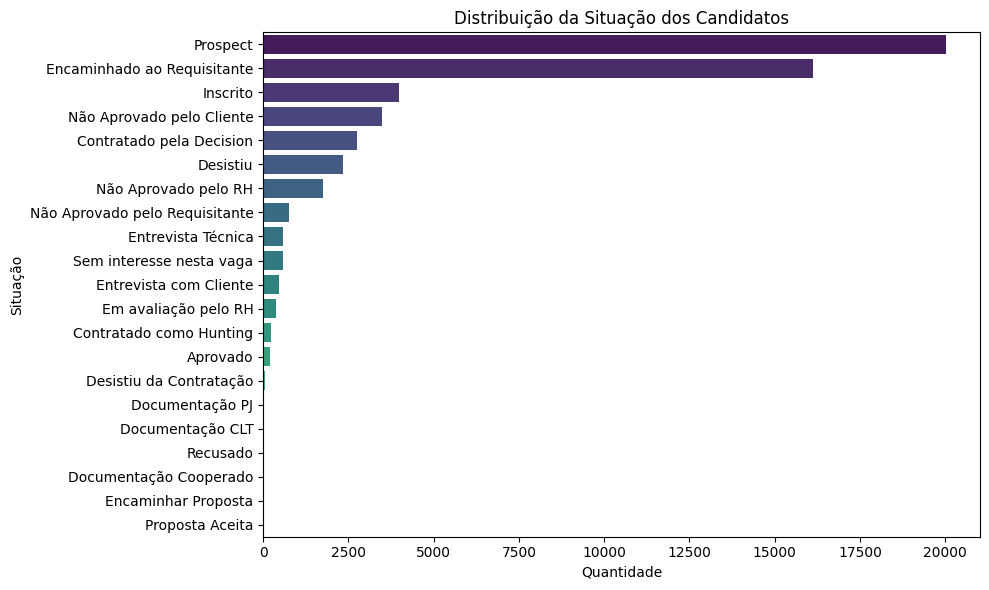

In [9]:
if 'situacao_candidado' in df_prospeccoes.columns:
    situacao_counts = df_prospeccoes['situacao_candidado'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=situacao_counts.values, y=situacao_counts.index, palette="viridis")
    plt.title("Distribuição da Situação dos Candidatos")
    plt.xlabel("Quantidade")
    plt.ylabel("Situação")
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'situacao' não encontrada. Verifique o nome correto.")


# 09 - Consolidando os dados em um único DataFrame
Nesta etapa, realizamos a fusão dos três DataFrames para criar um único conjunto de dados completo (df_completo).

Shape final do DataFrame consolidado: (53759, 109)
  id_vaga id_candidato           situacao_candidado
0    4530        25632  Encaminhado ao Requisitante
1    4530        25529  Encaminhado ao Requisitante
2    4531        25364     Contratado pela Decision
3    4531        25360  Encaminhado ao Requisitante
4    4533        26338     Contratado pela Decision
Colunas disponíveis em df_completo:
['nome', 'id_candidato', 'situacao_candidado', 'data_candidatura', 'ultima_atualizacao', 'comentario', 'recrutador', 'id_vaga', 'informacoes_basicas.data_requicisao', 'informacoes_basicas.limite_esperado_para_contratacao', 'informacoes_basicas.titulo_vaga', 'informacoes_basicas.vaga_sap', 'informacoes_basicas.cliente', 'informacoes_basicas.solicitante_cliente', 'informacoes_basicas.empresa_divisao', 'informacoes_basicas.requisitante', 'informacoes_basicas.analista_responsavel', 'informacoes_basicas.tipo_contratacao', 'informacoes_basicas.prazo_contratacao', 'informacoes_basicas.objetivo_vaga', 

/tmp/ipython-input-10-3643696012.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem.values, y=labels, palette="crest")


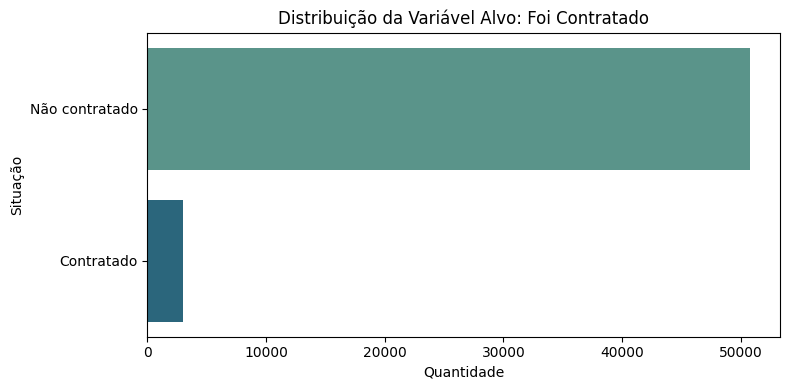


Tabela da variável alvo (`foi_contratado`):
           Classe  Quantidade  Percentual (%)
0  Não Contratado       50775           94.45
1      Contratado        2984            5.55
Valores nulos restantes por coluna:
perfil_vaga.estado                                0
perfil_vaga.cidade                                0
perfil_vaga.regiao                                0
perfil_vaga.nivel_academico                       0
perfil_vaga.nivel_ingles                          0
perfil_vaga.nivel_espanhol                        0
perfil_vaga.areas_atuacao                         0
perfil_vaga.vaga_especifica_para_pcd              0
informacoes_basicas.prioridade_vaga               0
informacoes_profissionais.area_atuacao            0
informacoes_profissionais.nivel_profissional      0
formacao_e_idiomas.nivel_academico                0
formacao_e_idiomas.nivel_ingles                   0
formacao_e_idiomas.nivel_espanhol                 0
formacao_e_idiomas.outro_idioma                   0
f

In [10]:
df_prospeccoes = df_prospeccoes.rename(columns={'codigo': 'id_candidato'})

df_completo = df_prospeccoes.merge(df_vagas, on='id_vaga', how='left')
df_completo = df_completo.merge(df_candidatos, on='id_candidato', how='left')

print(f"Shape final do DataFrame consolidado: {df_completo.shape}")
print(df_completo[['id_vaga', 'id_candidato', 'situacao_candidado']].head())

print("Colunas disponíveis em df_completo:")
print(df_completo.columns.tolist())

print("Registros em df_prospeccoes:", df_prospeccoes.shape[0])
print("Registros após merge (df_completo):", df_completo.shape[0])

print("Vagas ausentes no merge:", df_completo['informacoes_basicas.titulo_vaga'].isnull().sum())
print("Candidatos ausentes no merge:", df_completo['infos_basicas.nome'].isnull().sum())

print(df_prospeccoes['id_candidato'].dtype)
print(df_candidatos['id_candidato'].dtype)

df_completo[['id_candidato', 'id_vaga', 'situacao_candidado',
             'perfil_vaga.nivel_ingles', 'formacao_e_idiomas.nivel_ingles',
             'informacoes_profissionais.area_atuacao']].sample(5)

situacoes_contratado = ['Contratado pela Decision', 'Contratado como Hunting']

df_completo['foi_contratado'] = df_completo['situacao_candidado'].isin(situacoes_contratado).astype(int)

print("Distribuição da variável `foi_contratado`:")
print(df_completo['foi_contratado'].value_counts())

percentual = (df_completo['foi_contratado'].value_counts(normalize=True) * 100).round(2)
print("\nPercentual:")
print(percentual)

import matplotlib.pyplot as plt
import seaborn as sns

contagem = df_completo['foi_contratado'].value_counts().sort_index()
labels = ['Não contratado', 'Contratado']

plt.figure(figsize=(8, 4))
sns.barplot(x=contagem.values, y=labels, palette="crest")
plt.title("Distribuição da Variável Alvo: Foi Contratado")
plt.xlabel("Quantidade")
plt.ylabel("Situação")
plt.tight_layout()
plt.show()

contagem = df_completo['foi_contratado'].value_counts().sort_index()
percentual = df_completo['foi_contratado'].value_counts(normalize=True).sort_index() * 100

df_alvo = pd.DataFrame({
    'Classe': ['Não Contratado', 'Contratado'],
    'Quantidade': contagem.values,
    'Percentual (%)': percentual.round(2).values
})

print("\nTabela da variável alvo (`foi_contratado`):")
print(df_alvo)

colunas_modelo = [
    'perfil_vaga.estado',
    'perfil_vaga.cidade',
    'perfil_vaga.regiao',
    'perfil_vaga.nivel_academico',
    'perfil_vaga.nivel_ingles',
    'perfil_vaga.nivel_espanhol',
    'perfil_vaga.areas_atuacao',
    'perfil_vaga.vaga_especifica_para_pcd',
    'informacoes_basicas.prioridade_vaga',
    'informacoes_profissionais.area_atuacao',
    'informacoes_profissionais.nivel_profissional',
    'formacao_e_idiomas.nivel_academico',
    'formacao_e_idiomas.nivel_ingles',
    'formacao_e_idiomas.nivel_espanhol',
    'formacao_e_idiomas.outro_idioma',
    'formacao_e_idiomas.instituicao_ensino_superior',
    'formacao_e_idiomas.ano_conclusao',
    'foi_contratado']


df_modelo = df_completo[colunas_modelo].copy()

colunas_categoricas = df_modelo.select_dtypes(include=['object', 'category']).columns.tolist()
colunas_numericas = df_modelo.select_dtypes(include=['int64', 'float64']).columns.tolist()

from sklearn.impute import SimpleImputer

colunas_categoricas = df_modelo.select_dtypes(include=['object', 'category']).columns.tolist()
colunas_numericas = df_modelo.select_dtypes(include=['int64', 'float64']).columns.tolist()

if colunas_categoricas:
    imp_cat = SimpleImputer(strategy='constant', fill_value='Desconhecido')
    df_modelo[colunas_categoricas] = imp_cat.fit_transform(df_modelo[colunas_categoricas])

if colunas_numericas:
    imp_num = SimpleImputer(strategy='median')
    df_modelo[colunas_numericas] = imp_num.fit_transform(df_modelo[colunas_numericas])

print("Valores nulos restantes por coluna:")
print(df_modelo.isnull().sum().sort_values(ascending=False))

# 10 - Imports novas Bibliotecas


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, recall_score, f1_score
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
import joblib

# 11 - Definindo a variável alvo e treinando o modelo
Aqui, definimos a variável alvo (foi_contratado) e as variáveis independentes, além de dividir os dados em treino e teste.

In [12]:
y = df_modelo['foi_contratado']
X = df_modelo.drop(columns='foi_contratado')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 12 - Modelagem com Random Forest
Aqui, usamos o Random Forest para treinar o modelo. Utilizamos GridSearchCV para otimizar os hiperparâmetros.

In [13]:
colunas_categoricas = X_train.select_dtypes(include='object').columns.tolist()
colunas_numericas = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessador = ColumnTransformer([
    ('num', num_pipeline, colunas_numericas),
    ('cat', cat_pipeline, colunas_categoricas)
])



pipeline_rf = Pipeline([
    ('preprocessamento', preprocessador),
    ('classificador', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'classificador__n_estimators': [100, 200],
    'classificador__max_depth': [None, 10],
    'classificador__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
melhor_pipeline_rf = grid_search.best_estimator_

print("\nMelhores parâmetros RF:", grid_search.best_params_)
print("Melhor AUC validação cruzada RF:", grid_search.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits

Melhores parâmetros RF: {'classificador__max_depth': 10, 'classificador__max_features': 'sqrt', 'classificador__n_estimators': 200}
Melhor AUC validação cruzada RF: 0.7347517697466396


# 13 - Avaliação do modelo
Aqui, avaliamos a performance do modelo utilizando a acurácia e a matriz de confusão.

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 9, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 9, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Random Forest Final
Acurácia: 0.7567894345238095
              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     10155
         1.0       0.13      0.58      0.21       597

    accuracy                           0.76     10752
   macro avg       0.55      0.67      0.53     10752
weighted avg       0.92      0.76      0.82     10752

[[7790 2365]
 [ 250  347]]


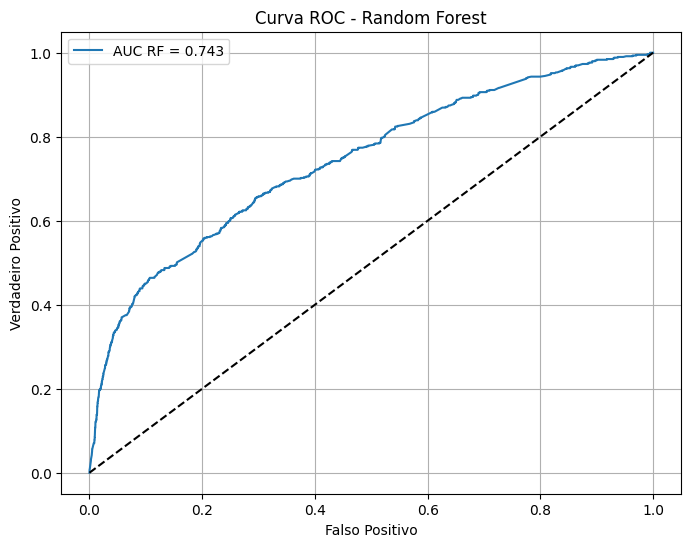

In [14]:
y_pred_rf = melhor_pipeline_rf.predict(X_test)
y_proba_rf = melhor_pipeline_rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Final")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'AUC RF = {auc_rf:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.grid()
plt.show()


# 14 - Comparação Final entre Modelos
Agora, vamos comparar os resultados dos dois modelos (Random Forest e XGBoost), levando em consideração a acurácia, o recall, o F1-score e o AUC (Área sob a Curva ROC).

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 9, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 9, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



XGBoost
Acurácia: 0.9450334821428571
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     10155
         1.0       0.57      0.04      0.07       597

    accuracy                           0.95     10752
   macro avg       0.76      0.52      0.52     10752
weighted avg       0.93      0.95      0.92     10752

[[10138    17]
 [  574    23]]


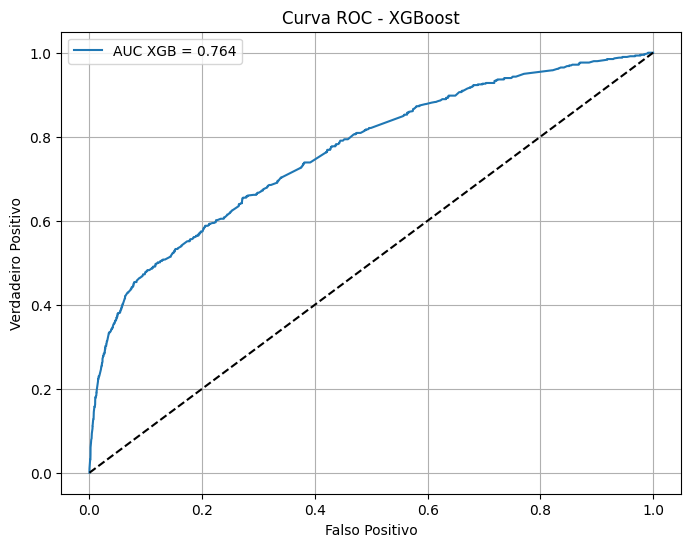

In [15]:
X_train_proc = preprocessador.fit_transform(X_train)
X_test_proc = preprocessador.transform(X_test)

modelo_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

modelo_xgb.fit(X_train_proc, y_train)

X_test_proc = preprocessador.transform(X_test)
y_pred_xgb = modelo_xgb.predict(X_test_proc)
y_proba_xgb = modelo_xgb.predict_proba(X_test_proc)[:, 1]


print("\nXGBoost")
print("Acurácia:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC XGB = {auc_xgb:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.grid()
plt.show()


# 15 - Comparação de Desempenho dos Modelos e salvamentos Pré-processadores para Produção
Essas ações asseguram que todo o processo, desde o treinamento até a aplicação do modelo em produção, esteja bem documentado e pronto para ser usado de forma eficiente e escalável.

In [16]:

df_resultados = pd.DataFrame([
    {
        'Modelo': 'Random Forest',
        'Acurácia': accuracy_score(y_test, y_pred_rf),
        'Recall Classe 1': recall_score(y_test, y_pred_rf),
        'F1 Classe 1': f1_score(y_test, y_pred_rf),
        'AUC': auc_rf
    },
    {
        'Modelo': 'XGBoost',
        'Acurácia': accuracy_score(y_test, y_pred_xgb),
        'Recall Classe 1': recall_score(y_test, y_pred_xgb),
        'F1 Classe 1': f1_score(y_test, y_pred_xgb),
        'AUC': auc_xgb
    }
])

print("\n📊 Comparativo Final:")
print(df_resultados)

joblib.dump(preprocessador, 'preprocessador.pkl')
joblib.dump(melhor_pipeline_rf, 'random_forest_pipeline.pkl')
joblib.dump(modelo_xgb, 'modelo_xgb.pkl')
joblib.dump(X_train.columns.tolist(), 'colunas_modelo.pkl')
X_train.to_csv('dados_treinamento.csv', index=False)


📊 Comparativo Final:
          Modelo  Acurácia  Recall Classe 1  F1 Classe 1       AUC
0  Random Forest  0.756789         0.581240     0.209731  0.742683
1        XGBoost  0.945033         0.038526     0.072214  0.764131


# 16 - Funções de Previsão de Candidatos
As funções permitem realizar previsões sobre a contratação de candidatos usando dois modelos de aprendizado de máquina, ajustando dinamicamente os dados de entrada e retornando tanto a classe prevista quanto a probabilidade associada.

In [17]:
def prever_candidato_rf(dados_dict, pipeline_rf, colunas_modelo):
    df_input = pd.DataFrame([dados_dict])

    for col in colunas_modelo:
        if col not in df_input.columns:
            df_input[col] = 0
    df_input = df_input[colunas_modelo]

    classe_predita = pipeline_rf.predict(df_input)[0]
    probabilidade = pipeline_rf.predict_proba(df_input)[0][1]

    return classe_predita, probabilidade

def prever_candidato_xgb(dados_dict, preprocessador, modelo_xgb, colunas_modelo):
    df_input = pd.DataFrame([dados_dict])

    for col in colunas_modelo:
        if col not in df_input.columns:
            df_input[col] = 0
    df_input = df_input[colunas_modelo]

    X_proc = preprocessador.transform(df_input)

    classe_predita = modelo_xgb.predict(X_proc)[0]
    probabilidade = modelo_xgb.predict_proba(X_proc)[0][1]

    return classe_predita, probabilidade


exemplo_candidato = {
    'formacao_e_idiomas.nivel_ingles': 3,
    'formacao_e_idiomas.nivel_espanhol': 1,
    'formacao_e_idiomas.nivel_academico': 4,
    'informacoes_profissionais.nivel_profissional': 2,
    'perfil_vaga.estado': 'SP'
}


classe_rf, prob_rf = prever_candidato_rf(
    dados_dict=exemplo_candidato,
    pipeline_rf=melhor_pipeline_rf,
    colunas_modelo=X_train.columns.tolist()
)

print(f"\nRandom Forest: Classe (0 não contratado, 1 contratado): {classe_rf}, Probabilidade de contratação: {prob_rf:.2%}")


classe_xgb, prob_xgb = prever_candidato_xgb(
    dados_dict=exemplo_candidato,
    preprocessador=preprocessador,
    modelo_xgb=modelo_xgb,
    colunas_modelo=X_train.columns.tolist()
)

print(f"XGBoost: Classe (0 não contratado, 1 contratado): {classe_xgb}, Probabilidade de contratação: {prob_xgb:.2%}")


Random Forest: Classe (0 não contratado, 1 contratado): 0.0, Probabilidade de contratação: 49.95%
XGBoost: Classe (0 não contratado, 1 contratado): 0, Probabilidade de contratação: 4.25%


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# ---------------

# 17 - App e instalação bibliotecas

In [21]:
!pip install streamlit
!pip install joblib
!pip install pyngrok

import streamlit as st
import pandas as pd
import joblib

preprocessador = joblib.load('preprocessador.pkl')
modelo = joblib.load('modelo_xgb.pkl')

# 18 - Final

01 - Definição de Campos e Opções:
São configurados campos para capturar dados da vaga (como estado, cidade, nível acadêmico e idiomas) e do candidato (como área de atuação, nível profissional e formação).

02 - Interface de Usuário:
Através do Streamlit, é criada uma interface para o usuário preencher as informações da vaga e do candidato por meio de seleções, campos de texto e inputs numéricos.

03 - Coleta de Dados:
Os dados fornecidos pelo usuário são coletados e organizados em um DataFrame.

04 - Pré-processamento e Previsão:

* Os dados são processados (transformação e limpeza).

* Um modelo treinado é usado para prever se a contratação será possível com base nas informações fornecidas.

05 - Exibição do Resultado:
A previsão é apresentada ao usuário, indicando se a contratação é "Sim" ou "Não".

In [22]:

campos = {
    'perfil_vaga.estado': 'Estado da vaga',
    'perfil_vaga.cidade': 'Cidade da vaga',
    'perfil_vaga.regiao': 'Região da vaga',
    'perfil_vaga.nivel_academico': 'Nível acadêmico da vaga',
    'perfil_vaga.nivel_ingles': 'Nível de inglês da vaga',
    'perfil_vaga.nivel_espanhol': 'Nível de espanhol da vaga',
    'perfil_vaga.areas_atuacao': 'Área de atuação da vaga',
    'perfil_vaga.vaga_especifica_para_pcd': 'Vaga específica para PCD?',
    'informacoes_basicas.prioridade_vaga': 'Prioridade da vaga',
    'informacoes_profissionais.area_atuacao': 'Área de atuação do candidato',
    'informacoes_profissionais.nivel_profissional': 'Nível profissional do candidato',
    'formacao_e_idiomas.nivel_academico': 'Nível acadêmico do candidato',
    'formacao_e_idiomas.nivel_ingles': 'Nível de inglês do candidato',
    'formacao_e_idiomas.nivel_espanhol': 'Nível de espanhol do candidato',
    'formacao_e_idiomas.outro_idioma': 'Outro idioma',
    'formacao_e_idiomas.instituicao_ensino_superior': 'Instituição de ensino superior',
    'formacao_e_idiomas.ano_conclusao': 'Ano de conclusão da formação'
}


estados = ['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal', 'Espirito Santo',
           'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Pará', 'Paraíba',
           'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro', 'Rio Grande do Norte', 'Rio Grande do Sul',
           'Rondônia', 'Roraima', 'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins']

regioes = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']

niveis_idioma_vaga = ['Avançado', 'Fluente', 'Nenhum', 'Básico', 'Intermediário', 'Técnico']
niveis_idioma_candidato = ['Nenhum', 'Intermediário', 'Básico', 'Avançado', 'Fluente']

outros_idiomas_candidato = [
    'Português - Fluente', 'Francês - Intermediário', 'Francês - Básico', 'Italiano - Avançado', 'Português -',
    'Italiano - Básico', 'Português - Avançado', 'Alemão - Básico', 'Alemão -', 'Japonês - Básico', 'Japonês -',
    'Alemão - Avançado', 'Japonês - Avançado', 'Alemão - Intermediário', 'Russo - Básico', 'Russo - Intermediário',
    'Italiano - Intermediário', 'Português - Intermediário', 'Japonês - Intermediário', 'Mandarim - Básico',
    'Francês - Avançado', 'Português - Nenhum', 'Italiano -', 'Português - Básico', 'Francês - Fluente',
    'Italiano - Fluente', 'Japonês - Fluente', 'Japonês - Nenhum', 'Russo - Fluente', 'Alemão - Nenhum',
    'Francês -', 'Alemão - Fluente'
]

outros_idiomas_vaga = [
    'Mandarim ou Russo', 'Nenhum', 'Avançado', 'Português Fluente', 'Português Avançado', 'Português Básico',
    'Francês Básico', 'Fluente', 'Básico', 'Francês Intermediário', 'Mandarim - Desejável', 'Alemão Fluente',
    'Francês Fluente', 'Alemão Avançado', 'Português Intermediário', 'Português'
]

areas_atuacao_vaga = [
    'TI - Sistemas e Ferramentas', 'TI - Desenvolvimento/Programação', 'TI - Projetos', 'TI - SAP',
    'TI - Infraestrutura', 'Gestão e Alocação de Recursos de TI', 'Administrativa',
    'TI - Processos e Negócios', 'Recursos Humanos', 'TI - Desenvolvimento/Design',
    'TI - Suporte', 'Financeira/Controladoria', 'TI - Desenvolvimento/Mobile', 'TI - Qualidade/Testes',
    'Comercial', 'TI - Banco de Dados', 'TI - Arquitetura', 'TI - Governança', 'TI - Telecom',
]


st.title('Previsão de Contratação - Decision AI')
st.markdown("### Preencha os dados da vaga e do candidato")

estado = st.selectbox(campos['perfil_vaga.estado'], estados)
cidade = st.text_input(campos['perfil_vaga.cidade'])
regiao = st.selectbox(campos['perfil_vaga.regiao'], regioes)
nivel_academico_vaga = st.selectbox(campos['perfil_vaga.nivel_academico'], niveis_idioma_vaga)
nivel_ingles_vaga = st.selectbox(campos['perfil_vaga.nivel_ingles'], niveis_idioma_vaga)
nivel_espanhol_vaga = st.selectbox(campos['perfil_vaga.nivel_espanhol'], niveis_idioma_vaga)
area_atuacao_vaga = st.selectbox(campos['perfil_vaga.areas_atuacao'], areas_atuacao_vaga)
vaga_pcd = st.selectbox(campos['perfil_vaga.vaga_especifica_para_pcd'], ['Sim', 'Não'])
prioridade_vaga = st.selectbox(campos['informacoes_basicas.prioridade_vaga'], ['Alta', 'Média', 'Baixa'])
area_atuacao_candidato = st.selectbox(campos['informacoes_profissionais.area_atuacao'], areas_atuacao_vaga)
nivel_profissional_candidato = st.selectbox(campos['informacoes_profissionais.nivel_profissional'], ['Júnior', 'Pleno', 'Sênior'])
nivel_academico_candidato = st.selectbox(campos['formacao_e_idiomas.nivel_academico'], niveis_idioma_candidato)
nivel_ingles_candidato = st.selectbox(campos['formacao_e_idiomas.nivel_ingles'], niveis_idioma_candidato)
nivel_espanhol_candidato = st.selectbox(campos['formacao_e_idiomas.nivel_espanhol'], niveis_idioma_candidato)
outro_idioma = st.selectbox(campos['formacao_e_idiomas.outro_idioma'], outros_idiomas_candidato)
instituicao_ensino = st.text_input(campos['formacao_e_idiomas.instituicao_ensino_superior'])
ano_conclusao = st.number_input(campos['formacao_e_idiomas.ano_conclusao'], min_value=1900, max_value=2025, step=1)

if st.button('Prever Contratação'):
    dados = {
        'perfil_vaga.estado': estado,
        'perfil_vaga.cidade': cidade,
        'perfil_vaga.regiao': regiao,
        'perfil_vaga.nivel_academico': nivel_academico_vaga,
        'perfil_vaga.nivel_ingles': nivel_ingles_vaga,
        'perfil_vaga.nivel_espanhol': nivel_espanhol_vaga,
        'perfil_vaga.areas_atuacao': area_atuacao_vaga,
        'perfil_vaga.vaga_especifica_para_pcd': vaga_pcd,
        'informacoes_basicas.prioridade_vaga': prioridade_vaga,
        'informacoes_profissionais.area_atuacao': area_atuacao_candidato,
        'informacoes_profissionais.nivel_profissional': nivel_profissional_candidato,
        'formacao_e_idiomas.nivel_academico': nivel_academico_candidato,
        'formacao_e_idiomas.nivel_ingles': nivel_ingles_candidato,
        'formacao_e_idiomas.nivel_espanhol': nivel_espanhol_candidato,
        'formacao_e_idiomas.outro_idioma': outro_idioma,
        'formacao_e_idiomas.instituicao_ensino_superior': instituicao_ensino,
        'formacao_e_idiomas.ano_conclusao': ano_conclusao
    }

    df = pd.DataFrame([dados])

    df_proc = preprocessador.transform(df)


    pred = modelo.predict(df_proc)

    st.success(f'A previsão de contratação é: {"Sim" if pred[0] == 1 else "Não"}')






2025-07-22 01:00:26.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 01:00:26.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 01:00:26.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 01:00:26.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 01:00:26.514 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 01:00:26.516 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 01:00:26.519 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 01:00:26.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar